In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
%matplotlib inline

In [83]:
kobe_frame = pd.read_csv('/Users/El-Razi/ds/metis/work_in_progress/proj3/data.csv')

## Data cleaning

In [11]:
# select usable features
kobe_frame = kobe_frame[['shot_made_flag','shot_type','combined_shot_type','shot_distance','shot_zone_area',
          'lat','loc_x','loc_y','lon','minutes_remaining','seconds_remaining','opponent',
         'period','game_date','playoffs']]

In [14]:
kobe_frame = kobe_frame.dropna()

In [15]:
# convert 'shot type' to integer
kobe_frame['shot_type'] = kobe_frame['shot_type'].apply(lambda x: 2 if x=='2PT Field Goal' else 3)

# convert minutes and seconds remaining into one col
kobe_frame['time_left'] = (kobe_frame.minutes_remaining*60) + kobe_frame.seconds_remaining

# '5' denotes overtime games
kobe_frame['period'] = [i if int(i)<=1 else 5 for i in kobe_frame['period']]

## Modeling

### Logit

In [33]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

In [31]:
y, X = dmatrices('''shot_made_flag ~ shot_type + combined_shot_type + shot_distance + 
                    shot_zone_area + lat + loc_x + loc_y + lon + minutes_remaining + 
                    seconds_remaining + opponent''',
                 data=kobe_frame, return_type='dataframe')

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1234)

# alt feature combinations
''' 'shot_made_flag','shot_type','combined_shot_type','shot_distance','shot_zone_area',
    'lat','loc_x','loc_y','lon','minutes_remaining','seconds_remaining','opponent',
    'period','game_date','playoffs' '''
''' combined_shot_type + shot_zone_area ''';

In [54]:
# confusion matrix: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# arbitrary classifier:

def train_score(classifier,xtrain,ytrain,xtest,ytest):
    #xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print "Training Data Accuracy: %0.2f" %(train_acc)
    print "Test Data Accuracy:     %0.2f" %(test_acc)
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print conf

    print '\n'
    print "Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0]))
    print "Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.62
Test Data Accuracy:     0.61
[[2385  417]
 [1589  749]]


Precision:              0.60
Recall:                 0.85


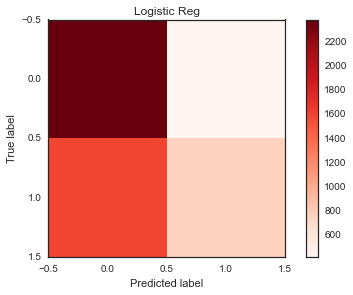

In [55]:
log_clf=LogisticRegression()
train_score(log_clf,xtrain,ytrain,xtest,ytest)
plt.title("Logistic Reg");

In [58]:
from sklearn.metrics import roc_auc_score
def ROC_viz(clf, xtrain,ytrain,xtest,ytest): 
    #xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = clf.fit(xtrain, ytrain)
    
    print 'fpr', roc_curve(ytest, clf.predict(xtest))[0][1]
    print 'tpr', roc_curve(ytest, clf.predict(xtest))[1][1]
    print 'auc:', roc_auc_score(ytest, clf.predict_proba(xtest)[:,1])
    
    roc=roc_curve(ytest,clf.predict_proba(xtest)[:,1])
    plt.figure()
    # Plotting our Baseline! 
    plt.plot([0,1],[0,1])
    plt.plot(roc[0],roc[1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

fpr 0.148822269807
tpr 0.320359281437
auc: 0.615266866084


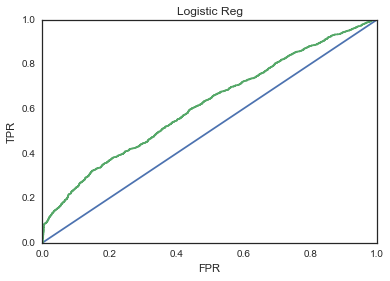

In [59]:
ROC_viz(log_clf,xtrain,ytrain,xtest,ytest)
plt.title("Logistic Reg");

#### Feature Selection

In [ ]:
from sklearn.feature_selection import RFE

In [42]:
rfe = RFE(log_clf, 8).fit(xtrain,ytrain)
print rfe.ranking_, rfe.score(xtrain,ytrain)

[44  1  2  1  3  1  1  1  1  1  1  4  7 34 13 32 37 38 23 26 20  8 30 14 24
 12 27  9 22 31  6 16 28 33 10 15 11 19 40 39 25 29 21  5 35 17 42 43 18 36
 41] 0.616237777886


### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

Training Data Accuracy: 1.00
Test Data Accuracy:     0.58
[[2094  708]
 [1472  866]]


Precision:              0.59
Recall:                 0.75


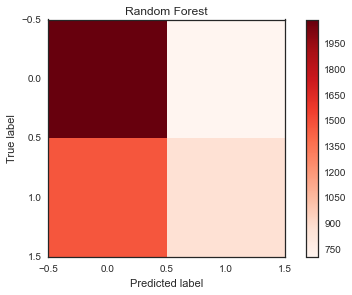

In [60]:
rfc_clf=RandomForestClassifier(n_estimators=500)
train_score(rfc_clf,xtrain,ytrain,xtest,ytest)
plt.title("Random Forest");

fpr 0.256245538901
tpr 0.365697177074
auc: 0.570899421713


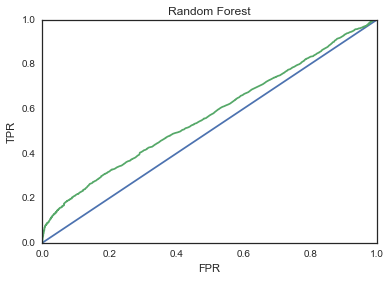

In [61]:
ROC_viz(rfc_clf,xtrain,ytrain,xtest,ytest)
plt.title("Random Forest");

Not so fast. Model is tremendously overfit.

#### Grid Search

In [64]:
from sklearn.grid_search import GridSearchCV
param_grid = {
              'n_estimators' : [1,10,100,1000]
             }
np.set_printoptions(suppress=True)
print(param_grid)

{'n_estimators': [1, 10, 100, 1000]}


In [66]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, cv=5, scoring='precision')

In [67]:
grid_search.fit(xtrain, np.ravel(ytrain))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=1)

In [68]:
grid_search.best_estimator_, grid_search.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False), 0.54730592145862644)

In [69]:
from sklearn.metrics import precision_score
grid_search.best_params_, precision_score(ytest,grid_search.predict(xtest)), grid_search.score

({'n_estimators': 1000},
 0.5457413249211357,
 <bound method GridSearchCV.score of GridSearchCV(cv=5, error_score='raise',
        estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
        fit_params={}, iid=True, n_jobs=1,
        param_grid={'n_estimators': [1, 10, 100, 1000]},
        pre_dispatch='2*n_jobs', refit=True, scoring='precision', verbose=1)>)

### Gradient Boosting

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [71]:
gbc = GradientBoostingClassifier()

In [72]:
gbc.fit(xtrain,np.ravel(ytrain))

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [73]:
print classification_report(ytest,gbc.predict(xtest)), accuracy_score(ytest,gbc.predict(xtest))

             precision    recall  f1-score   support

        0.0       0.60      0.84      0.70      2802
        1.0       0.63      0.32      0.42      2338

avg / total       0.61      0.61      0.57      5140
0.605642023346


In [74]:
param_grid_gbc = {
                 'min_samples_split': [1], 
               'min_samples_leaf' : np.arange(1, 5),
              'n_estimators' : np.arange(1, 30)
             }

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid_gbc, verbose=1, cv=5)

In [75]:
feature_imp = pd.DataFrame(rfc_clf.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index([u'seconds_remaining', u'minutes_remaining', u'lon', u'loc_x', u'loc_y',
       u'lat', u'shot_distance', u'combined_shot_type[T.Dunk]',
       u'combined_shot_type[T.Jump Shot]', u'opponent[T.SAS]',
       u'opponent[T.PHX]', u'opponent[T.DEN]', u'opponent[T.SAC]',
       u'opponent[T.HOU]', u'opponent[T.POR]', u'opponent[T.MIN]',
       u'opponent[T.UTA]', u'opponent[T.LAC]', u'opponent[T.DAL]',
       u'opponent[T.GSW]'],
      dtype='object')

## Visualization

In [77]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

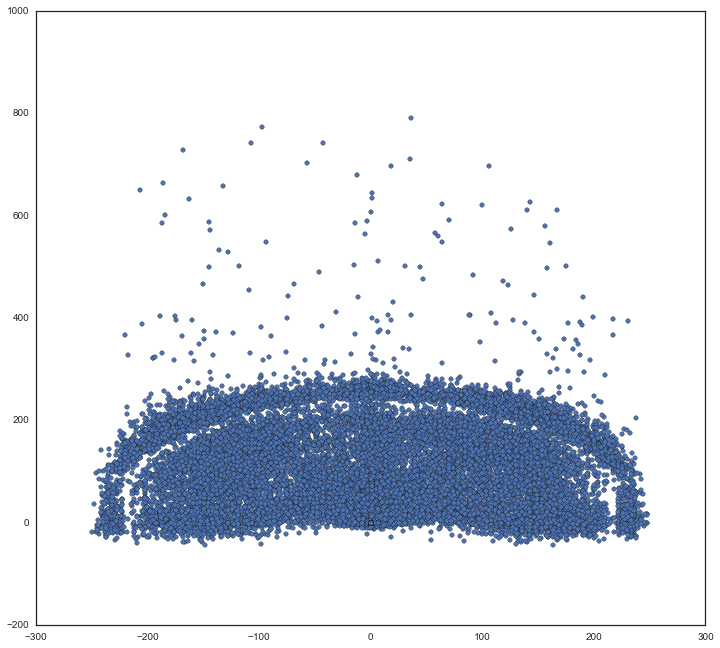

In [25]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(kobe_frame.loc_x, kobe_frame.loc_y)
plt.show();

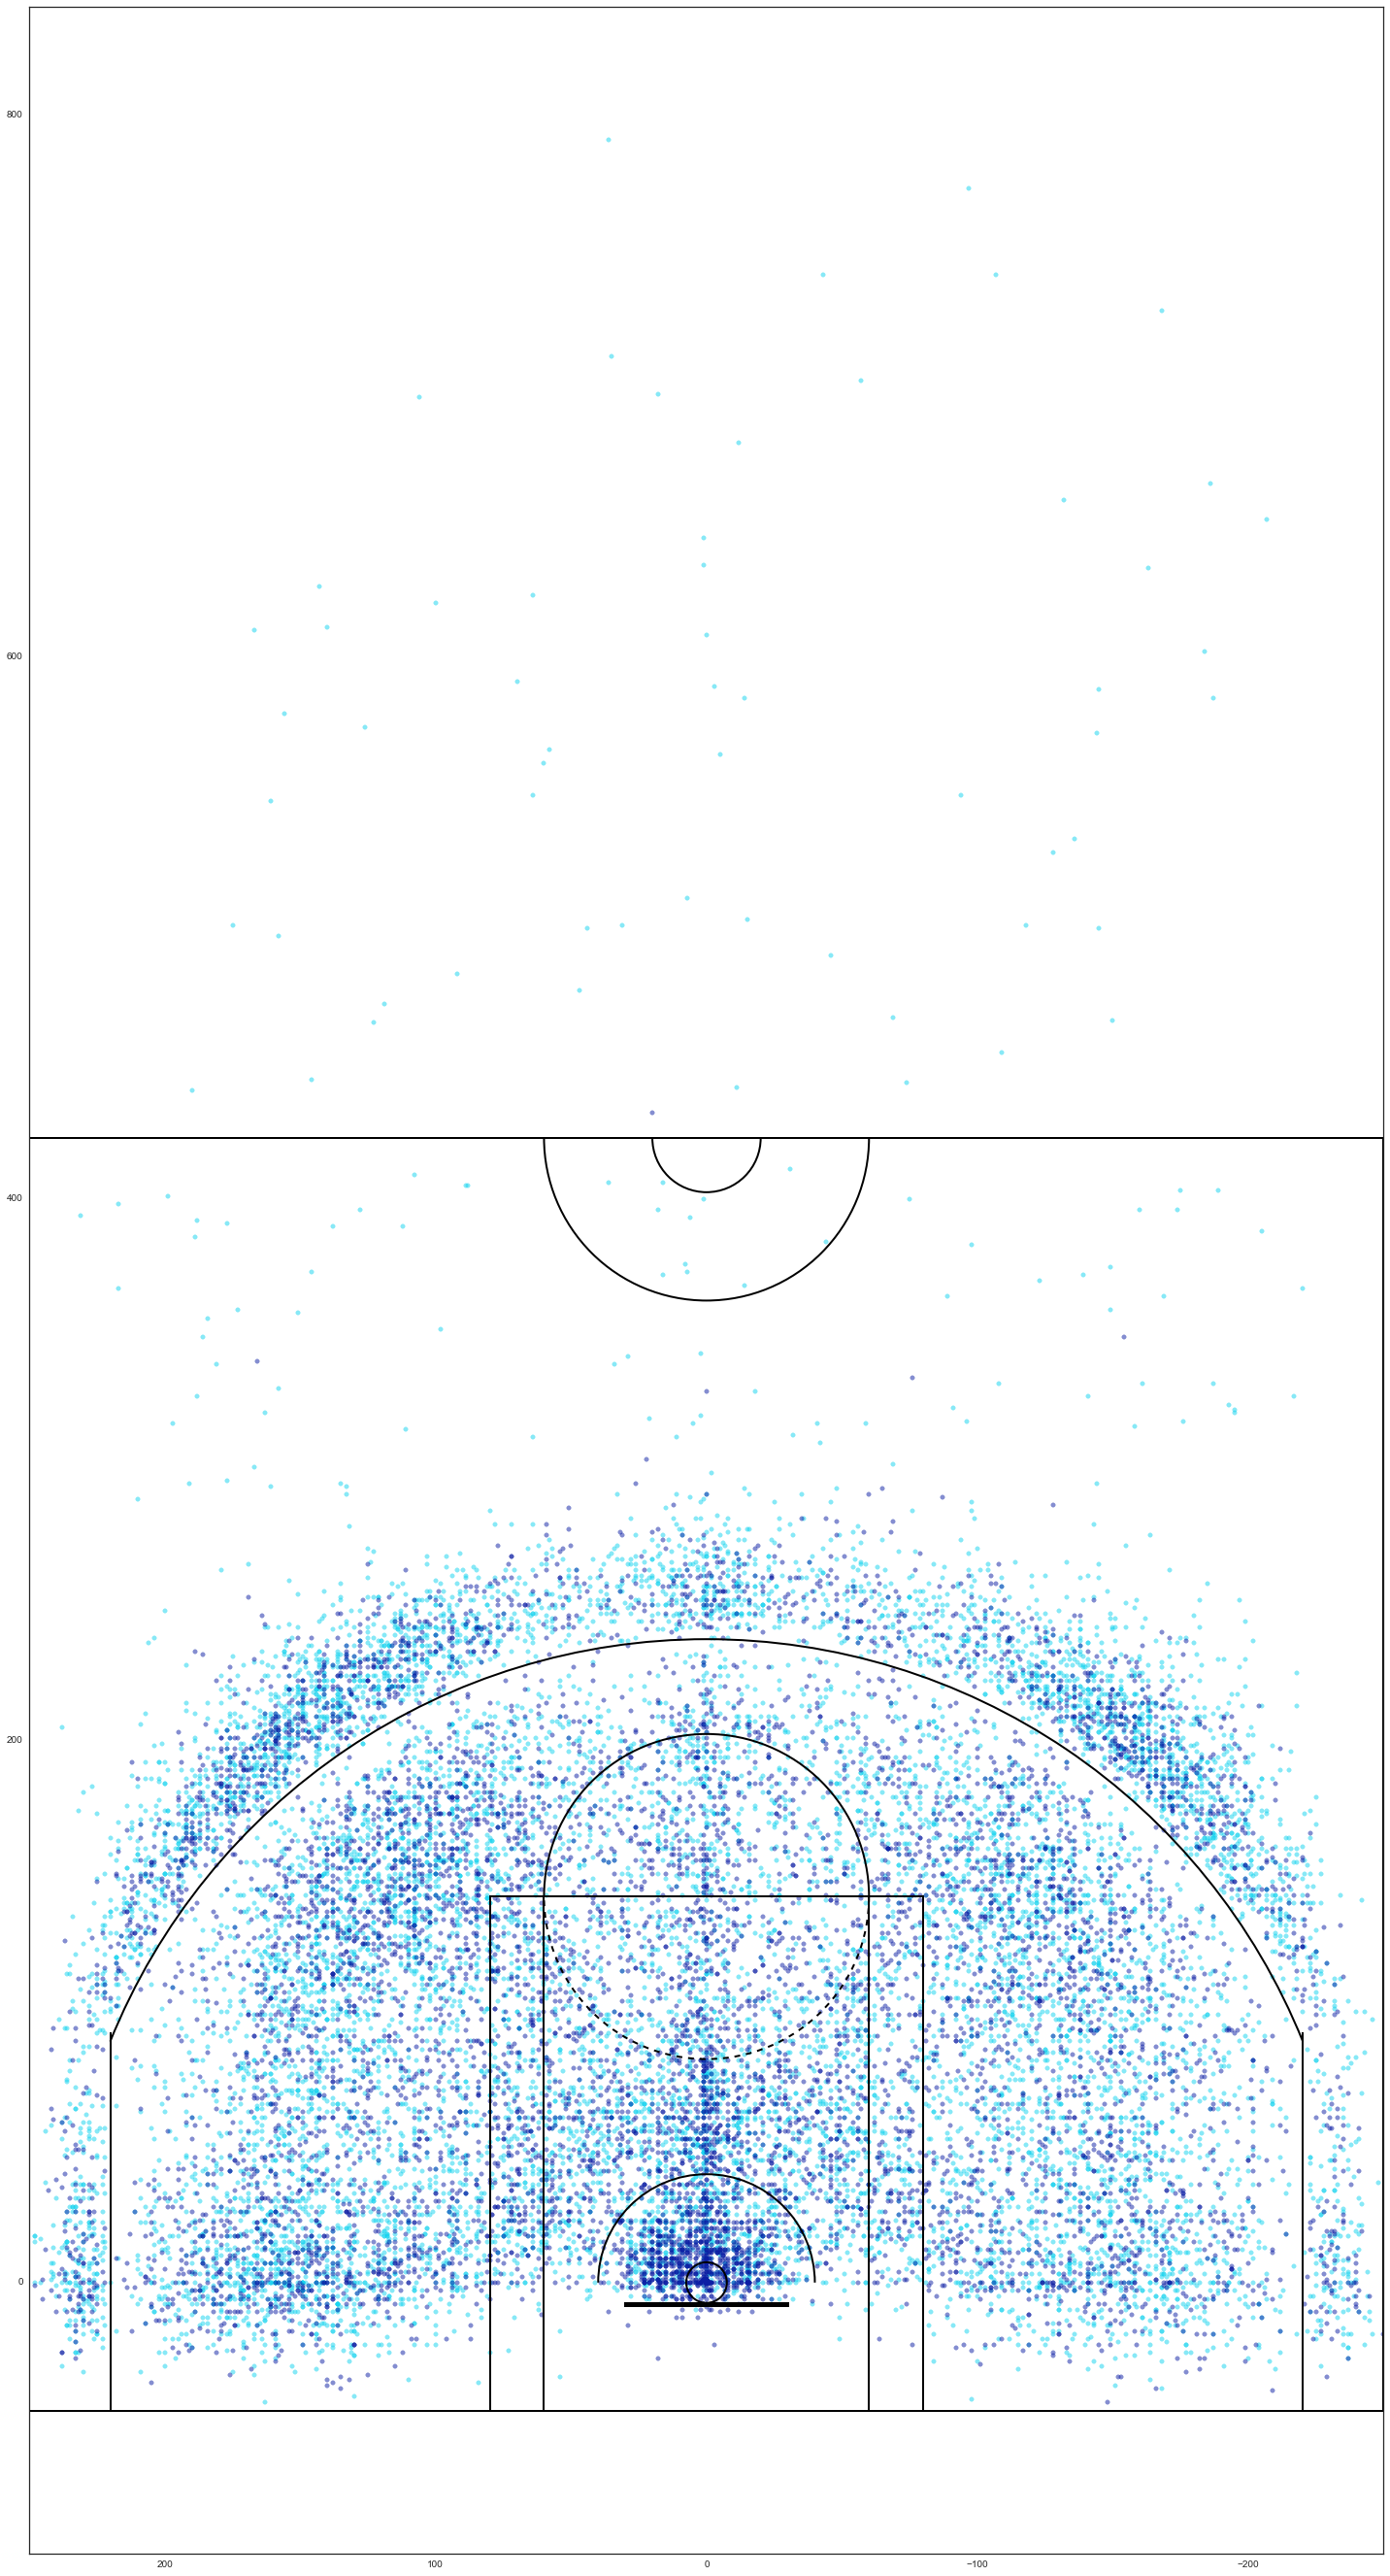

In [80]:
sns.set_style("white")
sns.set_color_codes()
all_shot_fig = plt.figure(figsize=(25,47),dpi=72)
all_shot_ax = all_shot_fig.add_subplot(111)

all_shot_ax.set_ylim([-100,840])
all_shot_ax.set_xlim([250,-250])

draw_court(ax=all_shot_ax,outer_lines=True)

# First, draw the missed shots
all_shot_ax.scatter(kobe_frame[
        (kobe_frame.shot_made_flag == 0)
    ].loc_x,
    kobe_frame[
        (kobe_frame.shot_made_flag == 0)
    ].loc_y,color='#13d4f0',alpha=0.50,marker="o")

# Then the made shots
all_shot_ax.scatter(kobe_frame[
        (kobe_frame.shot_made_flag == 1)
    ].loc_x,
    kobe_frame[
        (kobe_frame.shot_made_flag == 1)
    ].loc_y,color='#0c1ea5',alpha=0.50)

# save an svg of each season
#     all_shot_fig.savefig('shotchart_' + season_string + '.svg')

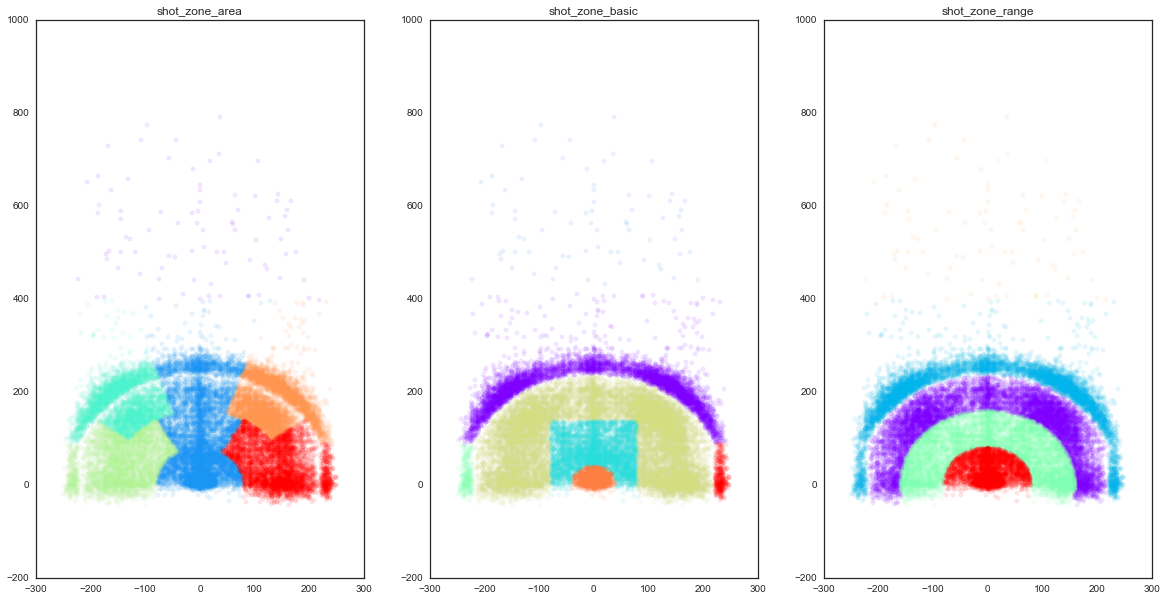

In [84]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = kobe_frame.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')